---

# P3:  Deep Learning Framwork: Pytorch를 이용하여 MLP 구현 (10점)

### 학습목표
- pytorch를 사용하여 구현된 MLP 구조를 이해하고 수정할수 있다.
- Fashinon-MNIST 문제를 스스로 해결하면서 딥러닝 학습과정을 이해하고 하이퍼파라미터를 튜닝을 할 수 있다.

### 실습내용
pytorch를 사용하여 구현 되어 있는 MLP를 통해 Fashion-MNIST 데이터셋을 분류하는 classfier를 학습합니다.

실습은 다음 순서로 진행됩니다.
- 1) Fashon-MNIST 데이터셋 설명
- 2) Data loading
- 3) Multilayer Perceptron Model
- 4) Training
- 5) Evaluation
- 6) Discussion

아래 코드에는 2개의 퍼셉트론은 이용한 MLP 모델이 정의 되어 있습니다.
실습을 시작하기전에 이 노트북 파일을 읽고 모든 셀을 실행해하여 올바르게 작동하는지 확인하세요.<br>
이후에 아키텍쳐를 마음껏 변경하여 최고의 성능이 나오도록 수정해 보세요.

**1. 다음은 변경 가능한 부분입니다.**
- activation 함수 (logistic sigmoid, tanh, relu, leaky relu, ...)
- learning rate
- hidden layers 갯수
- epochs
- minibatch size
- 각 hidden layer의 neuron 개수

**2. 그러나 다음 사항은 변경하지 마세요.**
- 가중치 초기화 방법
- 랜덤시드
- 최적화 방법, 학습 방법

**3. layer를 추가하여 2개 이상의 hidden layer를 구성할 수 있게 구현하세요.**

**4. 수정가능한 셀은 아래 주석으로 확실하게 하이라이트되어 표시되어 있습니다.**

```
############################################################
# 변경 가능한 셀
############################################################
```

### 점수
**Test set 기준**

- 정확도 85% 이상 2점
- 정확도 86% 이상 4점
- 정확도 87% 이상 6점
- 정확도 88% 이상 8점

**구현**
- Layer 수 2개 이상으로 구현: 2점

`.ipynb 파일과 함께 .html 파일 (File -> export as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.`

In [1]:
import torch
import os
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Document: https://pytorch.org/docs/stable/nn.functional.html
import matplotlib.pyplot as plt
# Document: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

In [2]:
# 이 부분은 절대 변경하지 마세요.

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1) Dataset 설명

이 데이터셋은 기존의 MNIST와 비슷하게 10개의 클래스로 이루어진 데이터셋입니다. 또한 흑백의 28x28크기, 60k개의 학습용 이미지와 10k개의 테스트용 이미지로 구성 되어 있는것과 같이 MNIST와 대부분 비슷한 구조로 이뤄져 있습니다. 

아래는 데이터셋의 샘플 이미지 입니다.

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

출처: https://github.com/zalandoresearch/fashion-mnist)



데이터셋의 10개의 클래스는 다음과 같습니다.


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 2) Dataset Loader

In [3]:
import torch
from PIL import Image
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import os

In [4]:
# Train 데이터 로딩시 이미지 데이터 전처리를 Transforms를 통해 할 수 있습니다.
# ToTensor는 PIL 형태의 이미지나 ndarray 를 PyTorch 가 이해할 수 있는 tensor 자료형으로 바꾸어 주는 역할을 하며
# Random Flip, Random Crop 등을 사용하여 Data augmentation을 수행하고 이를 통해 좋은 성능을 얻을 수 있습니다.
# 하지만, 이번 실습에서는 사용하지 않습니다.
# Document: https://pytorch.org/vision/stable/transforms.html
custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(), # pil같은 이미지를 불러오는 라이브러리에서 torch에 맞는 tensor형태로 변경
                                             transforms.Normalize(mean=(0.5,), std=(0.5,)) # 이미지를 정규화하여 학습 
])

In [5]:
# Test 데이터 로딩시 데이터 Transform
# Testset의 Trainsform은 Training set 과 다르게 랜덤하게 변경되면 안됩니다.
# 이번 실습에서는 사용하지 않습니다.
custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [6]:
############################################################
# 변경 가능한 셀
############################################################

# BATCH_SIZE = 60000을 사용하면 Full-Batch 학습
# BATCH_SIZE = 1을 사용하면 Online 학습
# BATCH_SIZE = N (1 < N < 60000) 을 사용하면 Mini-batch 학습
BATCH_SIZE = 256

# 데이터를 리스트에서 꺼내는게 아니라, 추상화된 클래스에서 빼서 쓰는거라 미리 batch size를 정함

In [7]:
train_dataset = FashionMNIST(".", train=True, download=True, transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, # dataloader가 batch_size만큼 가져옴 
                          shuffle=True, # 가져올 때 섞어서 가져옴
                          drop_last=True, 
                          num_workers=2) # 프로세스 수 


test_dataset = FashionMNIST(".", train=False, download=True, transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

아래 셀은 데이터셋이 잘 Load 되었는지 확인하는 테스트용 코드입니다.

특히, Label data의 경우 One-hot vector encoding 되기 전의 형태의 class label 정보입니다.

In [8]:
num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        print(f'Image data shape: \t {x.shape}')
        print(f'Label data shape: \t {y.shape}')
        print(y) # one hot encoding 전의 class 이름 
        break

Epoch: 1 | Batch index: 0 | Batch size: 256
Image data shape: 	 torch.Size([256, 1, 28, 28])
Label data shape: 	 torch.Size([256])
tensor([2, 7, 0, 6, 7, 5, 9, 6, 3, 1, 8, 8, 2, 9, 5, 4, 2, 6, 8, 8, 0, 4, 8, 8,
        1, 2, 1, 7, 4, 5, 0, 9, 4, 3, 0, 0, 5, 3, 2, 0, 4, 0, 6, 2, 1, 5, 5, 6,
        9, 3, 2, 1, 5, 2, 6, 8, 5, 0, 8, 4, 5, 2, 4, 3, 4, 9, 7, 7, 2, 5, 3, 6,
        8, 5, 6, 2, 9, 9, 2, 7, 7, 3, 3, 0, 1, 4, 4, 3, 5, 1, 3, 0, 8, 8, 1, 2,
        6, 3, 1, 0, 0, 9, 0, 9, 8, 9, 9, 3, 1, 5, 4, 9, 5, 1, 7, 8, 0, 1, 5, 2,
        5, 6, 5, 8, 2, 6, 8, 9, 0, 7, 9, 8, 7, 8, 0, 5, 4, 1, 5, 5, 4, 9, 2, 9,
        4, 4, 5, 3, 9, 0, 9, 6, 7, 6, 0, 9, 5, 4, 1, 3, 9, 8, 1, 5, 1, 9, 1, 9,
        3, 3, 8, 9, 1, 0, 6, 6, 4, 1, 6, 1, 0, 6, 9, 6, 3, 0, 4, 6, 2, 8, 1, 4,
        6, 8, 4, 5, 3, 8, 9, 0, 6, 1, 7, 6, 8, 2, 0, 0, 6, 0, 6, 3, 9, 6, 3, 2,
        8, 3, 3, 0, 6, 1, 6, 7, 2, 7, 0, 8, 4, 3, 1, 4, 2, 8, 3, 3, 1, 4, 7, 1,
        4, 8, 9, 9, 1, 3, 3, 5, 8, 6, 4, 0, 1, 8, 2, 4])


## 3) Multilayer Perceptron Model

아래 셀은 MLP모델을 정의하는 부분입니다. 이 과제에서 메인 부분입니다.<br>
Hidden layer이 2개가 되도록 변경하세요. 필요에 따라 3개 이상으로 늘려도 됩니다.

In [9]:
############################################################
# 변경 가능한 셀
############################################################

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes # 10 
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        
        # <your code> to add layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        
        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)
        
        self.linear_4 = torch.nn.Linear(num_hidden_3, num_hidden_4)
        
        self.linear_out = torch.nn.Linear(num_hidden_4, num_classes)
        
        # Multi-class classification 문제를 풀기 위해 Softmax 함수를 사용합니다.
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, x):
        
        ### activation 함수 변경 가능
        ### 레이어간의 연결 추가, 변경
        out = self.linear_1(x)
        out = torch.tanh(out)
        
        # <your code> to set the layer and the activation function
        out = self.linear_2(out)
        out = torch.tanh(out)
        
        out = self.linear_3(out)
        out = torch.tanh(out)
        
        out = self.linear_4(out)
        out = torch.tanh(out)
        
        logits = self.linear_out(out)
        
        # Multi-class classification 문제를 풀기 위해 Softmax 함수를 사용합니다.
        # 다만, 이후 사용할 F.cross_entropy() 함수 내부에 softmax가 이미 구현되어 있기 때문에
        # Loss function 계산 시에는 self.softmax()를 통과하기 전의 logits 값을 이용하게 됩니다.
        probas = self.softmax(logits)
        return logits, probas 

# random seed는 무작위 가중치 초기화가 항상 같도록 해줍니다.
# 초기화된 가중치에 따라 같은 네트워크도 서로 다른 성능을 낼 수 있어서 
# 실제 사용시에는 좋은 성능을 얻기 위해 여러가지 무작위 가중치를 시도해 볼 수 있습니다.
# 그러나 이 과제에서는 변경하지 않습니다.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 4) Training

**Cross entropy loss function 사용 시 주의점**

- 모델의 출력인 logits, probas의 차원은 [BATCH_SIZE, num_classes] 형태지만, 정답 Label인 targets 변수의 차원은 [BATCH_SIZE] 입니다. (ex, [1, 3, 2, 4, 9, ..., 3])


- 일반적으로 Cross Entropy Loss를 계산하기 위해서는 targets에 one-hot vector encoding을 수행해주어야 하지만, F.cross_entropy() 함수는 이를 내부적으로 수행해줍니다.


- 또한, F.cross_entropy() 함수 내부적으로 softmax 함수를 이용하기 때문에, 모델의 출력 중 probas 값이 아닌 logits 값을 이용하여 Loss function을 계산합니다.


- 구현 상세는 pytorch documents에서 확인할 수 있습니다. (https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy)

In [10]:
############################################################
# 변경 가능한 셀
############################################################

### num_hidden_1, num_hidden_2 변경 가능, 
### 레이어를 더 추가하고 싶다면 이부분을 알맞게 수정하세요.
model = MLP(num_features=28*28,
            num_hidden_1=40,
            num_hidden_2=40,
            num_hidden_3=40,
            num_hidden_4=40,
            num_classes=10)

model = model.to(DEVICE)


### Optimizer는 가중치를 업데이트하는 방법을 바꾸어 더 빠르게 좋은 성능을 낼 수 있도록합니다.
### 이 과제에서는 optimizer를 변경하지 않습니다. 
### 그러나 Learning Rate(lr)는 변경이 가능합니다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

NUM_EPOCHS = 50 # 변경 가능
############################################################

### 아래는 변경 불가능
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        
        # Loss 계산 시에는 logits 이용
        cross_entropy += F.cross_entropy(logits, targets).item()
        
        # 추론 시에는 probas 이용
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.cpu().float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad() # 이전 데이터에서 계산한 gradient가 다음 데이터에 영향을 주지 않도록
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 40:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Test Acc.: {test_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/234 | Cost: 2.3065
Epoch: 001/050 | Batch 040/234 | Cost: 1.8664
Epoch: 001/050 | Batch 080/234 | Cost: 0.8358
Epoch: 001/050 | Batch 120/234 | Cost: 0.8209
Epoch: 001/050 | Batch 160/234 | Cost: 0.7079
Epoch: 001/050 | Batch 200/234 | Cost: 0.6483
Epoch: 001/050 Train Acc.: 79.38% | Test Acc.: 77.98%
Time elapsed: 0.26 min
Epoch: 002/050 | Batch 000/234 | Cost: 0.5613
Epoch: 002/050 | Batch 040/234 | Cost: 0.5450
Epoch: 002/050 | Batch 080/234 | Cost: 0.5257
Epoch: 002/050 | Batch 120/234 | Cost: 0.5599
Epoch: 002/050 | Batch 160/234 | Cost: 0.5922
Epoch: 002/050 | Batch 200/234 | Cost: 0.5262
Epoch: 002/050 Train Acc.: 83.13% | Test Acc.: 82.15%
Time elapsed: 0.52 min
Epoch: 003/050 | Batch 000/234 | Cost: 0.4465
Epoch: 003/050 | Batch 040/234 | Cost: 0.5268
Epoch: 003/050 | Batch 080/234 | Cost: 0.3955
Epoch: 003/050 | Batch 120/234 | Cost: 0.4703
Epoch: 003/050 | Batch 160/234 | Cost: 0.4336
Epoch: 003/050 | Batch 200/234 | Cost: 0.3568
Epoch: 003/050 Tra

Epoch: 024/050 | Batch 080/234 | Cost: 0.3116
Epoch: 024/050 | Batch 120/234 | Cost: 0.2578
Epoch: 024/050 | Batch 160/234 | Cost: 0.1994
Epoch: 024/050 | Batch 200/234 | Cost: 0.2340
Epoch: 024/050 Train Acc.: 90.59% | Test Acc.: 86.97%
Time elapsed: 6.87 min
Epoch: 025/050 | Batch 000/234 | Cost: 0.1899
Epoch: 025/050 | Batch 040/234 | Cost: 0.3189
Epoch: 025/050 | Batch 080/234 | Cost: 0.3024
Epoch: 025/050 | Batch 120/234 | Cost: 0.2178
Epoch: 025/050 | Batch 160/234 | Cost: 0.2826
Epoch: 025/050 | Batch 200/234 | Cost: 0.2601
Epoch: 025/050 Train Acc.: 90.47% | Test Acc.: 87.00%
Time elapsed: 7.15 min
Epoch: 026/050 | Batch 000/234 | Cost: 0.2655
Epoch: 026/050 | Batch 040/234 | Cost: 0.2338
Epoch: 026/050 | Batch 080/234 | Cost: 0.1961
Epoch: 026/050 | Batch 120/234 | Cost: 0.2809
Epoch: 026/050 | Batch 160/234 | Cost: 0.2001
Epoch: 026/050 | Batch 200/234 | Cost: 0.2280
Epoch: 026/050 Train Acc.: 91.02% | Test Acc.: 87.00%
Time elapsed: 7.40 min
Epoch: 027/050 | Batch 000/234 | 

Epoch: 047/050 | Batch 160/234 | Cost: 0.1549
Epoch: 047/050 | Batch 200/234 | Cost: 0.2189
Epoch: 047/050 Train Acc.: 92.64% | Test Acc.: 87.23%
Time elapsed: 12.80 min
Epoch: 048/050 | Batch 000/234 | Cost: 0.2196
Epoch: 048/050 | Batch 040/234 | Cost: 0.1940
Epoch: 048/050 | Batch 080/234 | Cost: 0.2383
Epoch: 048/050 | Batch 120/234 | Cost: 0.2800
Epoch: 048/050 | Batch 160/234 | Cost: 0.2346
Epoch: 048/050 | Batch 200/234 | Cost: 0.2110
Epoch: 048/050 Train Acc.: 92.97% | Test Acc.: 87.47%
Time elapsed: 13.06 min
Epoch: 049/050 | Batch 000/234 | Cost: 0.1680
Epoch: 049/050 | Batch 040/234 | Cost: 0.1425
Epoch: 049/050 | Batch 080/234 | Cost: 0.2312
Epoch: 049/050 | Batch 120/234 | Cost: 0.2307
Epoch: 049/050 | Batch 160/234 | Cost: 0.2251
Epoch: 049/050 | Batch 200/234 | Cost: 0.2874
Epoch: 049/050 Train Acc.: 93.01% | Test Acc.: 87.34%
Time elapsed: 13.32 min
Epoch: 050/050 | Batch 000/234 | Cost: 0.1885
Epoch: 050/050 | Batch 040/234 | Cost: 0.1740
Epoch: 050/050 | Batch 080/234

## 5) Evaluation

테스트 데이터와 학습 데이터의 Loss변화를 확인합니다.

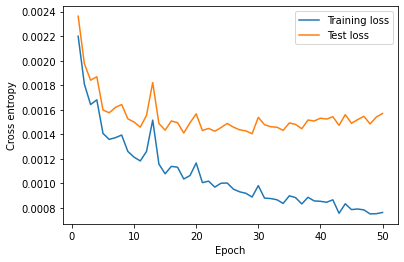

In [11]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_loss_lst, label='Test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

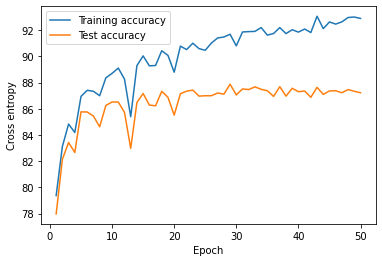

In [12]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='Test accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [13]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 87.23%


## 6) Discussion

**1) 학습, 테스트 정확도는 얼마인가요? (위 숫자를 복사하세요.)**

- Training:  92.90%
- Test 87.23%

**2) overfitting을 경험했나요? 만약 그랬다면 왜 그랬을지 적어보고, overfitting을 방지하기위한 간단한 방법은 무엇일까요?**

[제안하는 방법 적기]

모든 경우에서 overfitting이 발생했다. 과적합이 발생한 이유로는 MLP에서 다수의 layer를 통해 model fitting을 진행하다보니, training data에 대한 학습이 너무 과하게 진행되어 overfitting이 진행된 것 같다. overfitting을 방지하거나, 과적합이 일어나는 정도를 줄이기 위한 방법은 다음과 같다. 

1.validation set을 통한 early stopping 

training data를 학습하는 epoch가 많을수록, 과적합이 발생한다. 따라서 검증 집합을 통해 최적의 학습률에 학습을 중단하여 과적합을 방지할 수 있다.


2.활성함수로 reLU을 사용한다.

tanh나 시그모이드 같은 활성함수들에서는 은닉층의 개수가 늘어날수록 그래디언트 소멸이 발생할 수 있다. 따라서 해당 문제를 방지하기 위해서, 은닉층의 개수가 증가한다면 reLU 함수를 사용하여 과적합을 방지한다.  


3.규제 방법을 사용한다. 

릿지나 라쏘같은 규제를 통해 가중치를 조절하여 모델의 과대 적합을 방지할 수 있다.

**3) 만약 hidden layer 수가 늘어나면(3개 이상) 얻을 수 있는 장/단점은 무엇일까요?**

- 장점 

1. 은닉층의 개수를 늘림으로서, 노드가 충분하지 않더라도 모델에 대한 학습률을 증가시킬 수 있다. 

2. 은닉층의 개수를 늘린다면, 단순한 퍼셉트론으로 복합은 구조에 대한 분류를 진행할 수 있다. 

- 단점

1. 은닉층의 개수가 증가함에 따라 각 training data에 대한 적합률도 증가하고, 이에 의해 과잉적합이 발생할 가능성도 커진다. 

2. 학습에 사용되는 가중치와 변수들이 많아짐에 따라, 학습에 필요한 비용(시간)이 증가하게 된다. 

**4) 구현하면서 수정한 부분에 대해 작성하여 수정한 이유 및 성능향상이 생긴 이유에 대해 답해보세요.**

수정한 부분과 각 부분에 대한 설명은 다음과 같다. 

1.hidden layer의 개수를 2개에서 4개로 증가     

은닉층의 수를 증가시켜 학습률을 올리기 위해 코드를 수정했으며, 이에 따라 복잡한 모델 학습이 가능하게 되어 학습률이 증가하였다.
 

2.은닉층에 있는 노드 수를 (10,10,10)에서 (40,40,40,40)으로 증가 

앞선 1번과 유사한 이유로 노드를 증가시켜 학습률을 올리기 위해 코드를 수정했다. 수정에 의해 기존보다 더 복잡한 모델 구현이 가능하게 되어 학습률이 증가했다. 
    

3.epoch를 50으로 변경 

학습을 반복하는 횟수를 증가시켜 학습률을 올리기 위해 코드를 수정했다. 동일한 data에 대한 반복적 학습으로 학습률을 증가시킬 수 있었다. 
    
    
4.batch size를 64에서 256으로 증가 

앞서 1, 2, 3번을 통해 training data에 대한 학습률을 증가했지만, 과대적합이 발생하여 이를 방지하기 위해 batch size를 증가시켰다. 학습하는 단위를 증가시킴에 따라, 기존에 발생하던 noise가 줄고 과대적합 정도가 감소했다. 
    
    
5.학습률을 1에서 0.2로 변경 

앞선 4번과 마찬가지로, 기존 1~3번에 의한 과대적합을 방지하기 위해 학습률을 감소시켰다. 이에 따라 학습되는 정도가 조절되어 과대적합이 약간 감소했다. 
    
    
6.활성함수를 sigmoid에서 tanh로 변경 

기존 sigmoid에 대한 학습률이 앞선 방법들을 모두 적용해도 87%를 넘지못해 활성함수를 수정했다. tanh를 통해 87% 이상의 학습률을 얻을 수 있었으며, 이는 활성함수의 형태가 달라서 발생했다고 생각한다. 

    